# Predicting Stock Movements by Analyzing News Data

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('data/ravenpack_sample_20162018.csv')

In [20]:
df.columns

Index(['TIMESTAMP_UTC', 'RPNA_DATE_UTC', 'RPNA_TIME_UTC', 'RP_ENTITY_ID',
       'ENTITY_TYPE', 'ENTITY_NAME', 'POSITION_NAME', 'RP_POSITION_ID',
       'COUNTRY_CODE', 'RELEVANCE', 'TOPIC', 'GROUP', 'TYPE', 'SUB_TYPE',
       'PROPERTY', 'EVALUATION_METHOD', 'MATURITY', 'CATEGORY', 'ESS', 'AES',
       'AEV', 'ENS', 'ENS_SIMILARITY_GAP', 'ENS_KEY', 'ENS_ELAPSED', 'G_ENS',
       'G_ENS_SIMILARITY_GAP', 'G_ENS_KEY', 'G_ENS_ELAPSED',
       'EVENT_SIMILARITY_KEY', 'NEWS_TYPE', 'SOURCE', 'RP_STORY_ID',
       'RP_STORY_EVENT_INDEX', 'RP_STORY_EVENT_COUNT', 'PRODUCT_KEY',
       'COMPANY', 'ISIN', 'CSS', 'NIP', 'PEQ', 'BEE', 'BMQ', 'BAM', 'BCA',
       'BER', 'ANL_CHG', 'MCQ'],
      dtype='object')

In [21]:
df['ESS'].describe()

count    45300.000000
mean        53.362163
std         13.108964
min          0.000000
25%         49.000000
50%         50.000000
75%         61.000000
max        100.000000
Name: ESS, dtype: float64

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


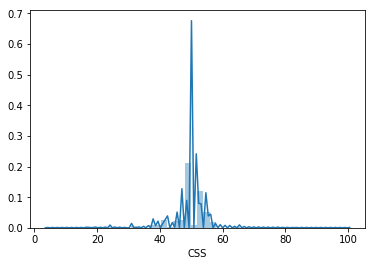

In [28]:
sns.distplot(df['CSS']);

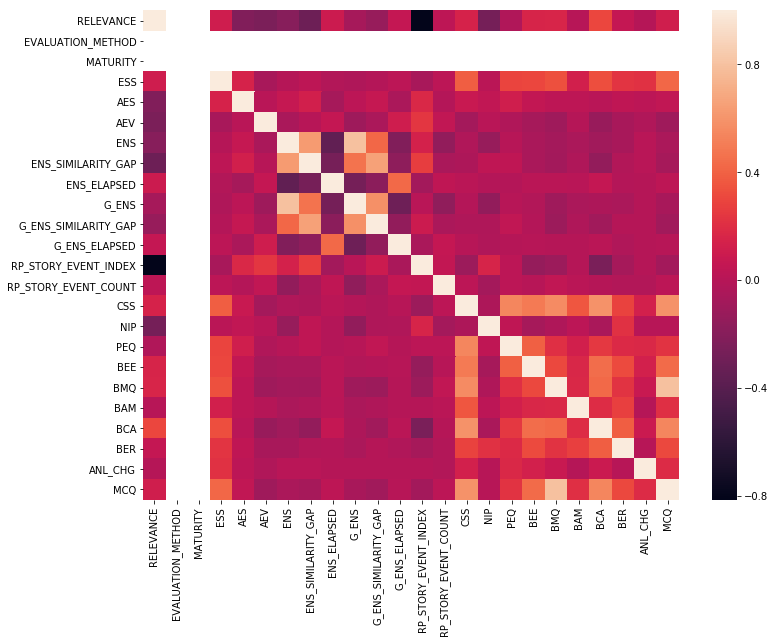

In [34]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat);

C:\Users\nicol\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


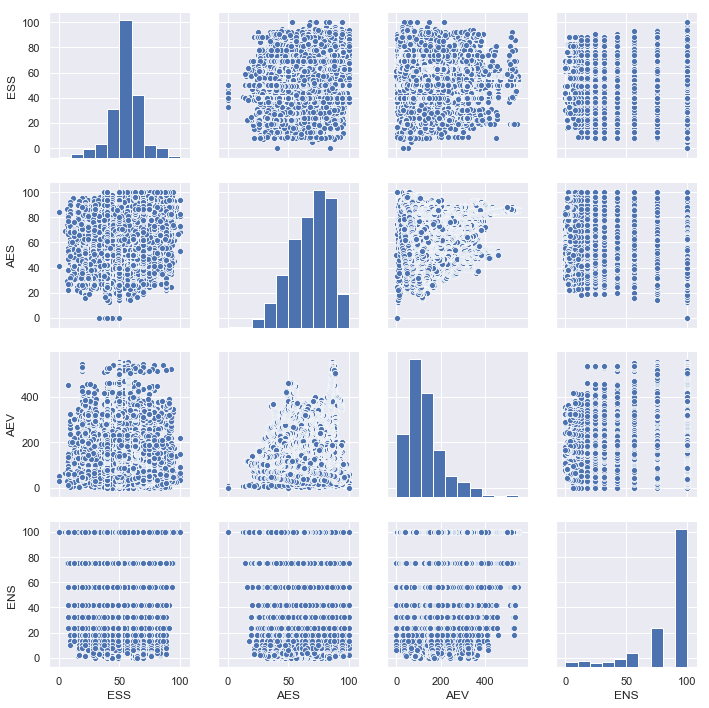

In [36]:
sns.set()
cols = ['ESS', 'AES', 'AEV', 'ENS']
sns.pairplot(df[cols], size = 2.5)
plt.show();